In [1]:
import torch
import sys
from os import listdir, path
import random
import re
import numpy as np
import cv2

sys.path.insert(0, '/home/steve/Dokumenty/Studia/project/ucsgnet-students-version')
sys.path.insert(0, '/home/steve/Dokumenty/Studia/project/CSGNet')

from ucsgnet.dataset import CADDataset, get_simple_2d_transforms, process_single_2d_image
import matplotlib.pyplot as plt
from src.Models.models import ParseModelOutput
from src.utils.generators.mixed_len_generator import Draw
from src.utils.train_utils import prepare_input_op, beams_parser, validity, image_from_expressions
from torch.utils.data import DataLoader

/home/steve/.conda/envs/ucsg/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
canvas_shape = [64, 64]
max_len = 19
terminals_path = '/home/steve/Dokumenty/Studia/project/CSGNet/terminals.txt'
cad_path = '/home/steve/Dokumenty/Studia/project/ucsgnet-students-version/data/cad/cad.h5'
cad_expr_path = '/home/steve/Dokumenty/Studia/project/CSGNet/data/cad/predicted_images/mix_len_cr_percent_equal_batch_3_13_prop_100_hdsz_2048_batch_2000_optim_adam_lr_0.001_wd_0.0_enocoderdrop_0.0_drop_0.2_step_mix_mode_12.pth/top_1_prediction/expressions'
# expr = ['expressions_old.txt', 'expressions_outT.txt', 'expressions.txt']
output_path = '/home/steve/Dokumenty/Studia/project/ucsgnet-students-version/data/cad'
# data_path = '/home/steve/Dokumenty/Studia/project/ucsgnet-students-version/data/synthetic/synthetic'
# output_path= '/home/steve/Dokumenty/Studia/project/ucsgnet-students-version/data/synthetic/'
# filepaths = {
#     k: path.join(path.join(data_path, k), 'expressions.txt') for k in listdir(data_path)
# }

with open(terminals_path, "r") as file:
    unique_draw = file.readlines()
for index, e in enumerate(unique_draw):
    unique_draw[index] = e[0:-1]

parser = ParseModelOutput(unique_draw, max_len // 2 + 1, max_len, canvas_shape)
# filepaths

In [3]:
dataset = CADDataset(cad_path, '', get_simple_2d_transforms())
loader = DataLoader(
            dataset=dataset,
            batch_size=1, # 16
            shuffle=False,
            drop_last=False,
            num_workers=0,
        )

In [4]:
def create_images(expressions, parser, output_name, counter, show=True, save=True):
    predicted_images = image_from_expressions(parser, expressions)
#     for i, img in enumerate(predicted_images):
#         plt.imshow(img, cmap="Greys")
#         plt.grid("off")
#         plt.axis("off")
    return predicted_images[0]
#         if save:
#             plt.savefig(path.join(output_path, f'{output_name}_{i+counter}'))
#         plt.clf()
        
def extract_primitives(expressions, output_name, save=True):
    def remove_ops(exp):
        return exp.replace('*', '').replace('-', '').replace('+', '') + '\n'
    out = path.join(output_path, output_name)
    primitives = [remove_ops(x) for x in expressions]
    if save:
        with open(out, 'w') as f:
            f.writelines(primitives)
    return primitives

def split_primitives(primitives):
    primitives_p = [x+')' for x in primitives.split(')')][:-1]
    return primitives_p


def calculate_one_sdf(primitive, parser):
    image = image_from_expressions(parser, primitive)
    return image

# def fill_primitives():
    

In [6]:
# Fill the expressions that you want to render
def read_expressions_or_primitives(filename):
    with open(filename, 'r') as f:
        exps = f.readlines()
    return list(map(lambda x: x.rstrip(), exps))

In [7]:
expressions = {
    'worse': read_expressions_or_primitives(path.join(cad_expr_path, 'expressions.txt')),
    'outT': read_expressions_or_primitives(path.join(cad_expr_path, 'expressions_outT.txt')),
    'old': read_expressions_or_primitives(path.join(cad_expr_path, 'expressions_old.txt'))
}
# primitives = extract_primitives(express, 'primitives_worse.txt')
primitives = {
    k: read_expressions_or_primitives(path.join(output_path, f'primitives_{k}.txt'))
    for k in expressions.keys()
}

In [11]:
def draw_primitive(primitive):
    shape = primitive[0]
    x, y, scale = re.findall("\d+", primitive)
    draw_obj = Draw(canvas_shape=(64, 64))
    draw_types = {
        "c": draw_obj.draw_circle,
        "s": draw_obj.draw_square,
        "t": draw_obj.draw_triangle
    }
    layer = draw_types[shape]([int(x), int(y)], int(scale))
    return layer

In [12]:
def draw_sample(index, key):
    counter = 0
    for batch in loader:
        if counter == index:
            image, points, trues, _ = batch
            image = image.reshape(64, 64)
#             plt.imshow(image, cmap='Greys')
#             plt.show()
#             plt.clf()
            break
        counter += 1
    sample_exp = expressions[key][index]
    sample = primitives[key][index]
    predicted = create_images([sample_exp], parser, '', 0, save=False)
    splitted = split_primitives(sample)
    predicted_images = [draw_primitive(pr) for pr in splitted]
    fig, axs = plt.subplots(1, len(predicted_images) + 2, figsize=(25, 3))
    fig.suptitle(key)
    axs[0].imshow(image, cmap='Greys')
#     axs[0].grid("off")
#     axs[0].axis("off")
    axs[0].set_title('original')
    axs[1].imshow(predicted, cmap='Greys')
#     axs[1].grid("off")
#     axs[1].axis("off")
    axs[1].set_title('predicted')
    for i in range(2, len(axs)):
        axs[i].imshow(predicted_images[i-2], cmap='Greys')
#         axs[i].grid("off")
#         axs[i].axis("off")
    return image, predicted, predicted_images

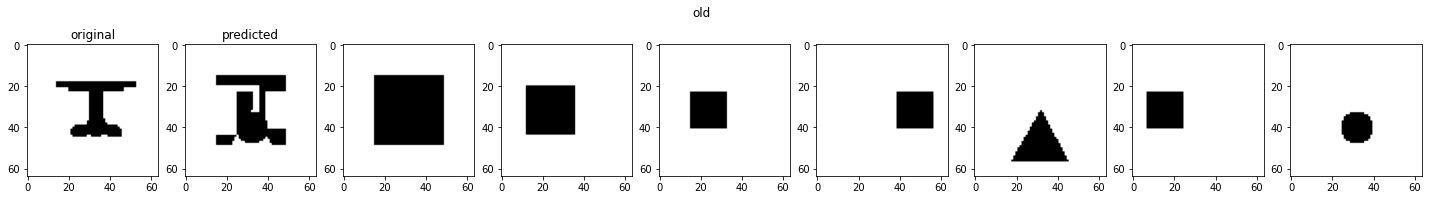

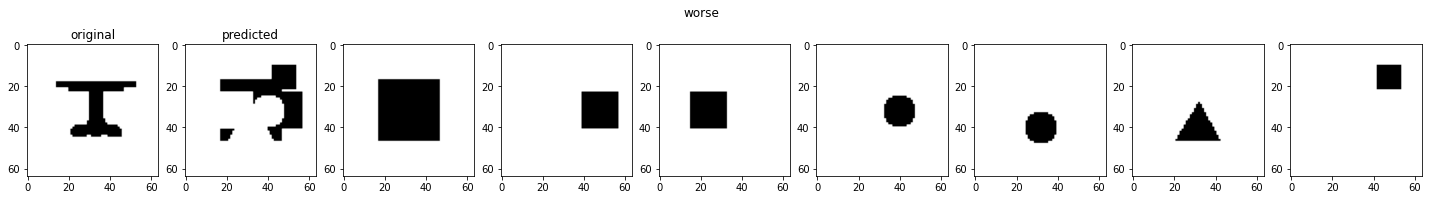

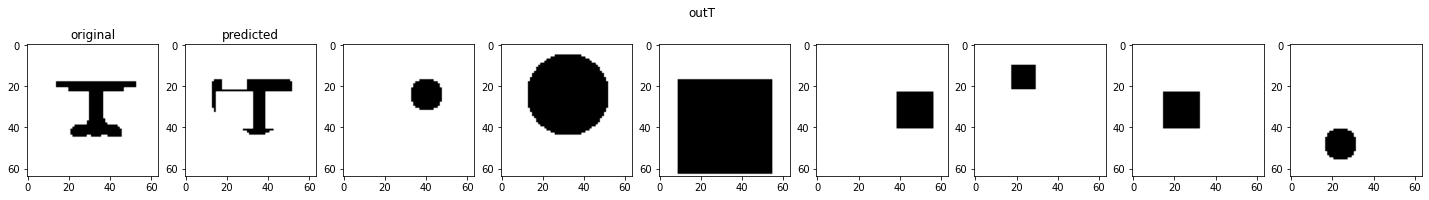

In [13]:
index = 201 #
original, predicted, pred_prim = draw_sample(index, 'old')
original, predicted, pred_prim = draw_sample(index, 'worse')
original, predicted, pred_prim = draw_sample(index, 'outT')

In [20]:
im_or = pred_prim[0].astype(np.float32)
im = cv2.cvtColor(im_or, cv2.COLOR_GRAY2BGR)
image, coords, trues, _ = process_single_2d_image(im, None)
im2 = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)

In [113]:
def transform_one_sample(sample, num_shapes=16, out_shape=64*64):
    # split primitives to list from string
    splitted = split_primitives(sample)
    # group primitives by shape type
    categories = {k:[] for k in ('s', 'c', 't')}
    for item in splitted:
        categories[item[0]].append(item)
    # change primitive parameters to numpy arrays
    categories = {k: [draw_primitive(p).astype(np.float32).reshape(-1) for p in ps] for k, ps in categories.items()}
    # multiply primitives (to have matrix num_shapes x out_shape)
    categories = {k: np.zeros((num_shapes, out_shape), dtype=np.float32)
                  if not arrs else np.array((arrs*(16//len(arrs) +1))[:16], dtype=np.float32)
                  for k, arrs in categories.items()}
    # concatenate all primitives to one array
    concatenated = np.concatenate([categories['s'], categories['c'], categories['t']])
    return concatenated

def transform_entire_dataset(dataset):
    transformed = map(lambda x: transform_one_sample(x), dataset)
    return np.stack(list(transformed))

In [114]:
sample = primitives['outT'][0]
label = transform_one_sample(sample)
label, label.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 (48, 4096))

In [117]:
transforms = transform_entire_dataset(primitives['old'])
transforms.shape

(3000, 48, 4096)

In [118]:
np.save(path.join(output_path,'cad_labels_1.npy'), transforms)

In [119]:
# load_test = np.load('cad_labels_1.npy')
# load_test.shape